<a href="https://colab.research.google.com/github/stephenllh/stylegan2-ada-latent-interpolation/blob/main/latent_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Setup

In [ ]:
!gdown https://drive.google.com/uc?id=12tgbW9Df4787867T2ZvDnbC9fr1sVze4
!gdown https://drive.google.com/uc?id=1JPqu5TVEIL4DwZ9cWFrDiwHQjKbGJ06Q
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git
import sys
sys.path.append("/content/stylegan2-ada-pytorch")

Downloading...
From: https://drive.google.com/uc?id=12tgbW9Df4787867T2ZvDnbC9fr1sVze4
To: /content/network-snapshot-004354.pkl
100% 283M/283M [00:05<00:00, 47.6MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JPqu5TVEIL4DwZ9cWFrDiwHQjKbGJ06Q
To: /content/latent_points.npy
100% 10.5M/10.5M [00:00<00:00, 16.2MB/s]
Cloning into 'stylegan2-ada-pytorch'...
remote: Enumerating objects: 128, done.
remote: Counting objects: 100% (128/128), done.
remote: Compressing objects: 100% (66/66), done.
remote: Total 128 (delta 58), reused 108 (delta 57), pack-reused 0
Receiving objects: 100% (128/128), 1.12 MiB | 29.42 MiB/s, done.
Resolving deltas: 100% (58/58), done.


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import torch
import IPython
import os
import warnings
warnings.filterwarnings("ignore")

### Functions

In [ ]:
with open('/content/network-snapshot-004354.pkl', 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()


def generate_image_from_z(z):
    with IPython.utils.io.capture_output() as captured:  # to prevent the printing of the error message "Setting up PyTorch plugin "bias_act_plugin"... Failed!"
        return G(z, None)


def tensor2numpy(img_tensor):
    if len(img_tensor.shape) != 3:
        img_tensor = img_tensor[0]
    img_tensor = torch.permute(img_tensor, (1, 2, 0))
    torch.clamp_(img_tensor, -1, 1)
    img_tensor = img_tensor / 2 + 0.5
    img = img_tensor.cpu().numpy()
    return img


def show_image(img_tensor):
    img = tensor2numpy(img_tensor)
    plt.axis("off")
    plt.imshow(img)


def show_images(img_tensor1, img_tensor2):
    img1 = tensor2numpy(img_tensor1)
    img2 = tensor2numpy(img_tensor2)
    fig, axes = plt.subplots(1, 2, figsize=(10, 20))

    axes[0].imshow(img1)
    axes[0].axis("off")

    axes[1].imshow(img2)
    axes[1].axis("off")
    

def slerp(val, low, high):
    """Spherical linear interpolation"""
    dot_product = np.dot(low / np.linalg.norm(low), high / np.linalg.norm(high))
    dot_product = np.clip(dot_product, -1, 1)
    omega = np.arccos(dot_product)
    so = np.sin(omega)
    if so == 0:
        return (1.0 - val) * low + val * high
    return np.sin((1.0 - val) * omega) / so * low + np.sin(val * omega) / so * high


def generate_random_image(seed=None):
    if seed is not None:
        torch.manual_seed(seed)
    z = torch.randn([1, G.z_dim]).cuda()
    return z, generate_image_from_z(z)


attribute_latent_points = {
    "Robot_color" : {
        "Red": [26, 166, 239, 250, 276, 408, 423, 468, 483, 1300, 1591],
        "Orange": [3, 6, 20, 32, 49, 51, 147, 153, 266, 362],
        "Yellow": [21, 67, 334, 459, 601],
        "Green": [35, 269, 426, 442, 1348, 1386, 1389, 1391, 1604],
        "Blue": [18, 257, 265, 257, 617, 618, 1348],
        "Purple": [353, 1173, 1395, 1654],
        "Black": [1, 60, 263, 395, 425],
        "Silver": [0, 360, 364, 505, 508, 602, 633],
        "White": [208, 341, 501, 1496, 1581, 1586],
    },
    "Complexity" : {
        "High": [16, 19, 11, 72, 78, 79, 83, 229, 230, 276],
        "Low": [12, 15, 66, 156, 209, 270, 428, 437, 440, 441],
    },
    "Direction" : {
        "Left": [12, 15, 200, 292, 317, 544, 552, 553],
        "Right": [0, 1, 3, 8, 9, 16, 17, 32, 107, 119],
        "Center": [4, 62, 110, 323, 543, 933, 1351],
    },
    "Size" : {
        "Fat": [41, 274, 486, 1291, 1300, 1353, 1486, 1820, 2515],
        "Thin": [66, 272, 285, 280, 315, 341, 371, 375, 394, 577, 2514],
    },
}

latent_points = np.load("latent_points.npy")

def get_latent_points_for_attributes(attribute, parameter):
    sample_idxs = attribute_latent_points[attribute][parameter]
    return latent_points[sample_idxs].mean(axis=0)


### Generate a random image

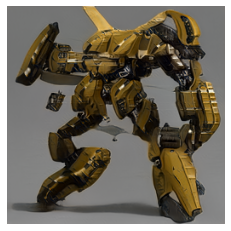

In [ ]:
z, old_img = generate_random_image(seed=100)
show_image(old_img)

### Control the parameters 
There are 5 provided parameters that you can control:
1. Robot color
2. Background color
3. Robot size
4. Robot's structure complexity
5. Robot's facing direction

#### Robot color

In [ ]:
Robot_color = "Silver" #@param ["Red", "Orange", "Yellow", "Green", "Blue", "Purple", "Black", "Silver", "White"]
Robot_color_weight =  1#@param {type: "number"}

Size = "Thin" #@param ["Fat", "Thin"]
Size_weight =  1#@param {type: "number"}

Complexity = "Low" #@param ["High", "Low"]
Complexity_weight = 1 #@param {type: "number"}

Direction = "Right" #@param ["Left", "Center", "Right"]
Direction_weight =  0#@param {type: "number"}

### Generate new image

In [ ]:
def generate_image_after_controlling_latent(old_z):
    old_z = old_z.cpu().numpy()
    robot_color_latent = get_latent_points_for_attributes("Robot_color", Robot_color)
    background_color_latent = get_latent_points_for_attributes("Background_color", Background_color)
    robot_size_latent = get_latent_points_for_attributes("Size", Size)
    complexity_latent = get_latent_points_for_attributes("Complexity", Complexity)
    direction_latent = get_latent_points_for_attributes("Direction", Direction)

    new_z += Robot_color_weight * slerp(Robot_color_weight, old_z, robot_color_latent)
    new_z += Size_weight * slerp(Size_weight, new_z, robot_size_latent)
    new_z += Complexity_weight * slerp(Complexity_weight, new_z, complexity_latent)
    new_z += Direction_weight * slerp(Direction_weight, new_z, direction_latent)

    print("Parameter settings:")
    print(f"Robot color: {Robot_color} with a weight of {Robot_color_weight}")
    print(f"Background color: {Background_color} with a weight of {Background_color_weight}")
    print(f"Size: {Size} with a weight of {Size_weight}")
    print(f"Complexity: {Complexity} with a weight of {Complexity_weight}")
    print(f"Direction: {Direction} with a weight of {Direction_weight}")

    img = generate_image_from_z(torch.tensor(new_z).cuda())
    show_images(old_img, img)

Parameter settings:
Robot color: Silver with a weight of 1
Background color: Red with a weight of 0
Size: Fat with a weight of 0
Complexity: High with a weight of 0
Direction: Right with a weight of 0


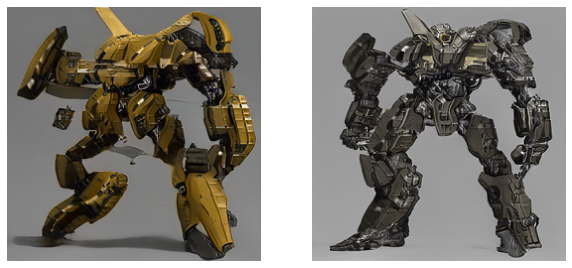

In [ ]:
generate_image_after_controlling_latent(z)

Parameter settings:
Robot color: Purple with a weight of 1
Background color: Red with a weight of 0
Size: Fat with a weight of 0
Complexity: High with a weight of 0
Direction: Right with a weight of 1


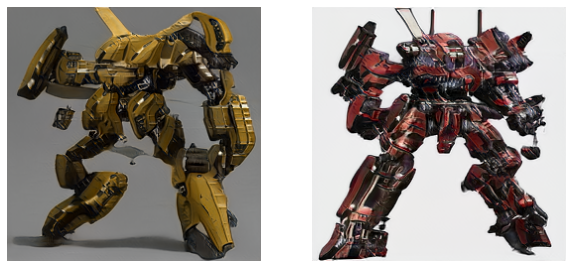

In [ ]:
generate_image_after_controlling_latent(z)